In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Set up Web Driver
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

In [2]:
# Set up Chrome options for headless mode
chrome_options = Options()
chrome_options.add_argument('--headless')  
chrome_options.add_argument('--disable-gpu')  # Disable GPU acceleration (needed in headless mode)
chromedriver_path = r"C:\Users\menon\Documents\Programming\Baby_Names_Project\chromedriver-win64\chromedriver-win64\chromedriver"

driver = webdriver.Chrome(executable_path=chromedriver_path, options=chrome_options)

C:\Users\menon\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  import sys


In [3]:
# Initalize list that will hold the user input
years_to_query = []

In [4]:
def ask_user():
    '''
    This function asks the user which year(s) they would like to search and creates a list from the response.
    '''
    # Ask user for year(s) to query website for
    x = input("What year or years would you like to search?\nIf entering a range, please use this format: 1900-1910.\nIf entering a list, use commas between years. ex: 1900, 1950, 2000.\n")
    
    # Process the response and populate the list "years_to_query" in preparation for website submission
    if x.find("-") != -1:
        # Slice and make list from range
        loc = x.find("-")
        range_start = x[:loc]
        range_end = x[loc+1:]
        for year in range(int(range_start),int(range_end)+1):
            years_to_query.append(year) 
       
    elif x.find(",") != -1:
        # Create list from string and send to other functions
        commas = x.count(",")
        # Search for white spaces and remove them before assigning indices for commas
        if x.find(" ")!= -1:
            x = x.replace(" ","")
        # locate first comma and use for loop to create list of years
        loc = x.find(",")
        for instance in range(0,commas+1):
            year = x[loc-4:loc]
            years_to_query.append(year)
            loc +=5
    else:
        # If only a single year, append directly
        years_to_query.append(x)

In [5]:
def get_names(list):
    '''
    This function takes the output from ask_user() and loops through the list. For each year in the list, it:
     - finds the appropriate search box on the webpage
     - clears it
     - inputs a year into the search box
     - clicks submit
     - creates a table of the 20 most popular names for that year that were scraped from the website
     - increments the counter by one to search the next year (if applicable) and repeats, appending each new scrape
       to the previous.
     - returns a 2D list of names
    '''
    # loop through all subsequent years and collate results
    list_of_names = []
    for year in list:
        time.sleep(1)        
        # Find the text box
        input_year = driver.find_element(By.ID,'yob') # locates input box
        input_year.clear()                             # clears box
        # Enter the year in question
        input_year.send_keys(str(year))           # fills in box with new date
        time.sleep(1)                                  # adds in delay of one second
        # Clicks button to submit request
        input_year.submit()                           
    
        # Scrape results
        top_names = driver.find_elements(By.XPATH,"//html/body/table[2]/tbody/tr/td[2]/p/table") # Table path that includes each year's table title for clarity

        for name in top_names:
            list_of_names.append(name.text)
                     
    return list_of_names

In [6]:
def clean_zip_split(list1, list2): # list1 = names, list2 = years_to_query
    '''
    This function takes the list of names generated by the "get_names()" function and cleans it by:
    - creating a 2D table
    - splitting the strings in each list on the newline character
    - removing unnecessary rows
    - creating a separate list of the first row in each sub-list, which will become DF column headers, and then removing 
      that row
    - splitting the list again, this time on the first space and dropping everything to the left of that space
    
    It then "zips" them together into a single dictionary, with each set of results associated with the relevant year.
    
    Next, it splits the male and female names while maintaining the correct year association.
    '''
    table = []
    names = []
    cleaned_list = []
    popularity = []
    combined_dict ={}
    new_dict = {}
    
    # First step - Create 2d table (list of lists)    
    for year in list1:
        table.append([year])
        
    # Second step - Split list and list of lists within each year    
    for result in table:
        for year in result:
            each_name = year.split("\n")
            names.append(each_name)
            
    # Third step - drop the two unwanted rows
    for i in names:
        i.pop(1)
        i.pop(-1)
            
    # Fourth step - split results in list based on first white space and only keep part after the split    
    for year in names:
        popularity.append(year[0])
        del year[0]
        result = [item.split(' ', 1)[1] for item in year]
        cleaned_list.append(result)      
    
    # Fifth step - "zip" the years list and names list together and create a dictionary of the result          
    for year, value, in zip(list2,cleaned_list):
        if year in combined_dict:
            combined_dict[year].append(value)
        else:
            combined_dict[year] = value

    # Sixth step - loop through the dictionary and separate the female names from the male names. Reassociate 
    # years to each set of name results to create two sex-specific dictionaries of names by year searched.
    
    for year, names_list in combined_dict.items():
        first_half_names = [name.split()[0] for name in names_list]
        second_half_names = [name.split()[1] for name in names_list]
        new_dict[year] = second_half_names
        combined_dict[year] = first_half_names

    return count_names(combined_dict), count_names(new_dict)

In [7]:
def count_names(dictionary):
    '''
    This function takes a (sex-specific) dictionary, converts it into a DataFrame, and creates a list of unique names. 
    It then iterates through the DataFrame to count the number of occurrences of each name in the set of results. 
    '''
    unique_names = []
    name_counts = {}
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame(dictionary)

    # Step 2 = iterate through the DataFrame and check if each value is already in the list of names. If not, 
    #append it to the list. 
    for index, row in df.iterrows():
        for col in df.columns:
            name = row[col]
            if name not in unique_names:
                unique_names.append(name)

    # Step 3 - loop through the names in the DataFrame and count occurrences
    for name in unique_names:
        count = (df == name).values.sum()
        name_counts[name] = count
    sorted_dict = dict(sorted(name_counts.items(),key=lambda item: item[1], reverse=True))

    return sorted_dict

In [8]:
'''
Main code to run the program. This cell: 
- calls the webdriver and website. (If website doesn't load, click refresh button at top of page.) 
- locates the correct text box, clears it, and calls the "ask_user()" function
- populates the search box with the first year and clicks the submit button to get to the page that will be scraped
- calls the "get_names()" function
- calls the "clean_zip_split()" function, converts each of the two results into a Series and stores results as variables
'''

# Visit the website homepage. If website doesn't load, click refresh button at top of page. 
try:
    driver.get('https://www.ssa.gov/OACT/babynames/')
except NoSuchElementException as e:
    driver.navigate().refresh()
    time.sleep(2)
    driver.navigate().refresh()

# Find the button, enter the year, and submit the form for the initial search
time.sleep(2)

input_year = driver.find_element(By.XPATH,'//*[@id="year"]')  
input_year.clear()
time.sleep(1)

# Get user input
ask_user()

# Load first year into input box
input_year.send_keys(str(years_to_query[0]))                                                
time.sleep(1)

# Perform initial search of first year in requested range in order to get to the correct page.
# If website doesn't load results, click refresh button at top of page
try:
    input_year.submit()

except NoSuchElementException as e:
    driver.navigate().refresh()
    time.sleep(2)
    driver.navigate().refresh()
    
# Call "get_names" function, which will perform all subsequent searches, collate results, and save them to the "list" variable    
list_of_names = get_names(years_to_query)

# Call "clean_zip_split" function to take the scraped results and create a clean dictionary with each name associated to the search year.
# Convert each result to a Series that can be used for graphing.

male_srs = pd.Series(clean_zip_split(list_of_names, years_to_query)[0])
female_srs = pd.Series(clean_zip_split(list_of_names, years_to_query)[1])

# Print results
print(male_srs)
print(female_srs)

What year or years would you like to search?
If entering a range, please use this format: 1900-1910.
If entering a list, use commas between years. ex: 1900, 1950, 2000.
1960-1975
David          16
Michael        16
John           16
James          16
Robert         16
Mark           16
William        16
Richard        16
Brian          16
Thomas         16
Jeffrey        16
Steven         16
Kevin          16
Joseph         16
Daniel         16
Scott          15
Christopher    11
Timothy        11
Charles        10
Paul            9
Jason           6
Eric            6
Matthew         5
Kenneth         5
Donald          1
Anthony         1
dtype: int32
Mary         16
Lisa         16
Elizabeth    16
Kimberly     14
Susan        12
Karen        12
Laura        12
Julie        12
Jennifer     11
Michelle     11
Angela       11
Tammy        11
Patricia     10
Amy           9
Melissa       9
Cynthia       9
Pamela        9
Christine     9
Donna         8
Sandra        8
Linda         7
Lori

In [9]:
driver.quit()

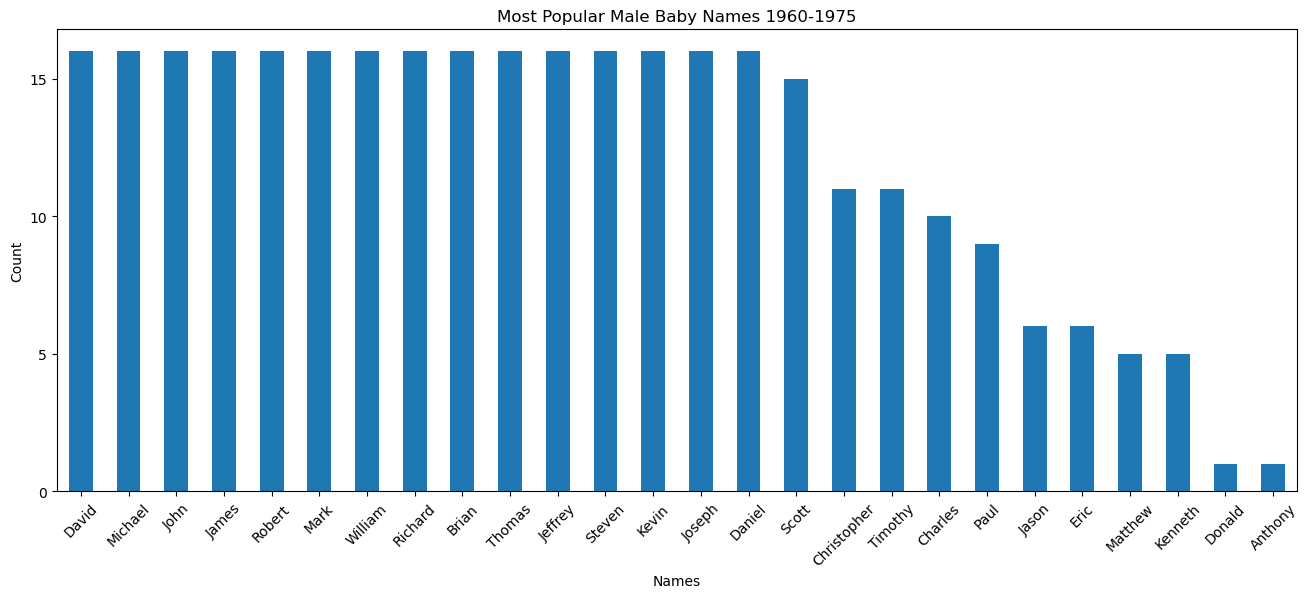

In [10]:
# Create a chart to show how many times in the year range each male name showed up in the top 20 results

# Set the figure size to fill the entire output area
plt.figure(figsize=(16, 6))  # Adjust the width and height as needed

ax = male_srs.plot(kind='bar')

# Set the y-axis tick values to increment by 5
y_ticks = range(0, max(male_srs) + 1, 5)
ax.set_yticks(y_ticks)

# Angle the x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.title(f'Most Popular Male Baby Names {years_to_query[0]}-{years_to_query[-1]}')
plt.xlabel('Names')
plt.ylabel('Count')

plt.show()

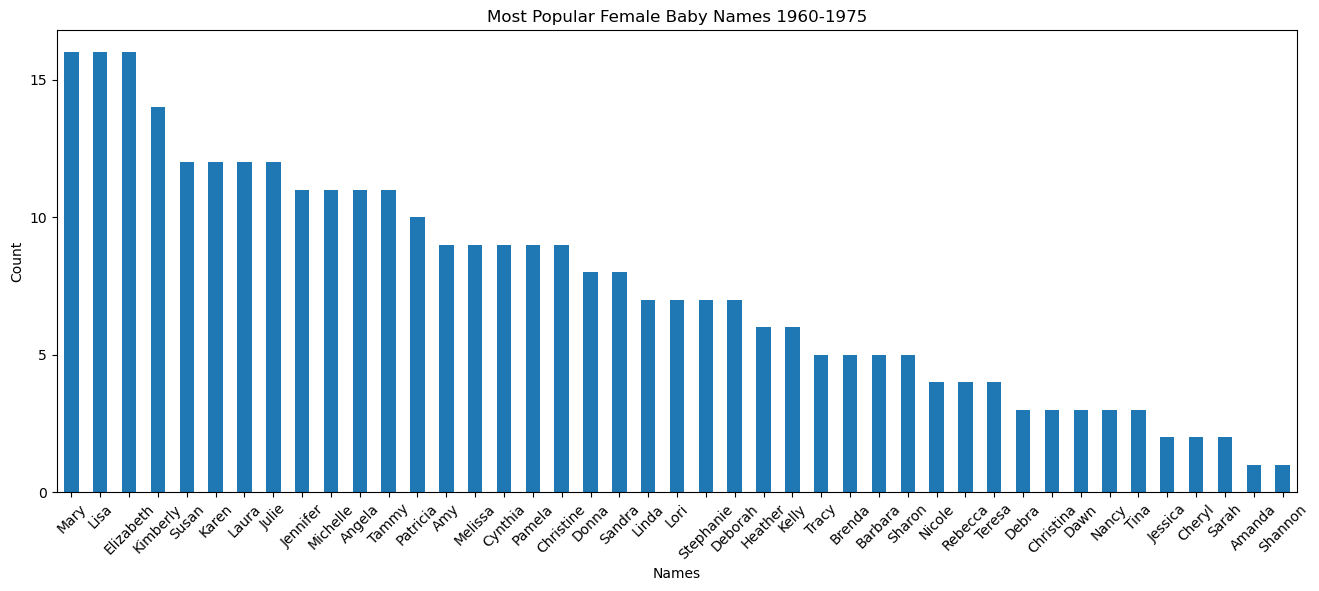

In [11]:
# Create a chart to show how many times in the year range each female name showed up in the top 20 results

# Set the figure size to fill the entire output area
plt.figure(figsize=(16, 6))  # Adjust the width and height as needed

ax = female_srs.plot(kind='bar')

# Set the y-axis tick values to increment by 5
y_ticks = range(0, max(female_srs) + 1, 5)
ax.set_yticks(y_ticks)

# Angle the x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.title(f'Most Popular Female Baby Names {years_to_query[0]}-{years_to_query[-1]}')
plt.xlabel('Names')
plt.ylabel('Count')

plt.show()